In [3]:
!pip install tqdm

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import scipy.stats as stats
import pickle
import matplotlib.patches as mpatches
truncnorm = stats.truncnorm
truncexp = stats.truncexpon
%matplotlib inline

In [28]:
# Oracle for a given weights matrix
def dijk(w):
    # Dijkstra
    # set initial conditions
    L = int(math.sqrt(len(w))) # number of vertices
    w = w.reshape(L,L)
    unvisited = list(range(L))
    distances = [np.inf]*L
    distances[0] = 0
    paths = [[0]]*L

    while len(unvisited) > 0:
        i = np.argmin([distances[i] for i in unvisited])
        v = unvisited[i]
        unvisited.pop(i)
        for u in range(L):
            if distances[u] > distances[v] + w[v, u]:
                distances[u] = distances[v] + w[v, u]
                paths[u] = paths[v][:]
                paths[u].append(u)
    
    short = paths[-1]
    # store observed paths
    A = np.arange(L**2).reshape(L,L)
    out = []
    for i in range(len(short)-1):
        out.append(A[short[i], short[i+1]])
        
    A = np.zeros(L**2)
    A[out] = 1
    return(out, A)

In [ ]:
V = 10
L = V*V
diag_zero = np.ones(L).reshape(V, V) - np.diag(np.ones(V))
path_means1 = np.zeros(L).reshape(V, V)
for i in range(V):
    for j in range(V):
        path_means1[i,j] = abs(i - j)/V - 1/(V*2)
path_means1 = abs(path_means1 * diag_zero)*10
upper = np.amax(path_means1)
lower = np.amin(path_means1)
path_means2 = np.random.uniform(0, 1, L).reshape(V, V) * diag_zero
path_means2[0,-1] = 1 # to try to make sure best path isn't to go straight to the end!

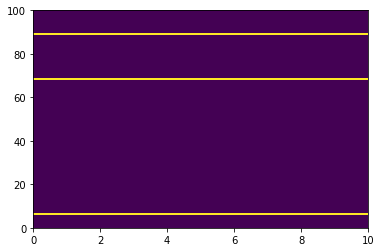

In [47]:
path_means1 = pickle.load( open( 'stoch_path_means', 'rb' ) )
w_actual = pickle.load(open('stoch_weights', 'rb'))
V = path_means1.shape[0]
L = V*V
lower=0
upper=1
sigma=0.1
path_means1 = truncnorm.stats(np.concatenate(lower-path_means1)/sigma, np.concatenate(upper-path_means1)/sigma, loc=np.concatenate(path_means1), scale=sigma, moments='m').reshape(V, V)
plt.pcolormesh(np.repeat(dijk(path_means1.reshape(L,))[1],10).reshape(L,10))

In [ ]:
np.sum(path_means1.reshape(L,)[dijk(path_means1.reshape(L,))[1].astype(bool)])

In [30]:
# Wan, Kveton and Ashkan 2015 CombLinTS algorithm
# Should work better than other algorithms when L is very large as doesn't depend on L
# Makes use of Lxd generalization matrix Φ of features for each element of E
# w̄ lies on or close to subspace span of Φ
# define θ∗ = argmin_θ ||w̄ − Φθ||_2
# could think of features as for example knowledge of other activities/events which affects outcome - 
# like characteristics of movies which could predict rating??


# Scenario: User knows Φ matrix of activities/events
# At each stage user samples coefficients θ used to estimate w̄
# and uses this estimate with oracle to determine which move to play
# observes weight for each play and updates parameters of θ sampling accordingly

### Set parameters
#L = 16 # 4x4 grid with 16 possible edges
lambda_true = 0.1 # (used to generate true coefficients of Φ which are then used to calculate w̄ )
sigma_true = 0.2 # (used when adding noise to true w at each iteration)
d = L
#phi = np.random.normal(0, 1, (L,d))
phi = np.eye(L)
#phi = np.random.uniform(0, 1, L*d).reshape(L,d)
#theta_opt = np.random.multivariate_normal([0]*d, np.diag([lambda_true**2]*d))
w_bar = path_means1.reshape(L,)
#w_bar = np.array([0,100,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
#w_bar = np.array([0,10,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
theta_opt = np.linalg.solve(phi,w_bar)

In [31]:
# Shortest path case for toy example
iters = 10000
w_est = np.zeros((L, iters))
#w_actual = np.zeros((L, iters))
A = np.zeros((L, iters))
theta = np.zeros((d, iters+1))
### INIT
t=0
lamb = 10
sigma = 0.1
cov_mat = [np.diag([lamb**2]*d)]*(iters+1)
theta[:,t] = [0]*d

In [32]:
### iterate over number of iterations
for t in tqdm(range(iters)):
    # draw sample theta and use to estimate w
    theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])
    w_est[:,t] = np.maximum(np.dot(phi, theta_sample),0)
    # Solve oracle for w_est and get A_t - can be any number of elements
    (edges, A[:,t]) = dijk(w_est[:,t])

    # calcualate actual w based on theta_opt plus some noise
    #w_actual_noise = np.random.normal(0, sigma_true**2, L)
    #w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)
    #w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means1)/sigma_true, (upper-path_means1)/sigma_true, loc=path_means1, scale=sigma_true)*diag_zero)
    
    # update covariance matrix and theta
    # init
    theta[:,(t+1)] = theta[:,t]
    cov_mat[t+1] = cov_mat[t]
    for k in edges:
        # update theta
        theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),(phi[k,:][np.newaxis]))) / 
                              (np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2))) , 
                (theta[:,(t+1)].reshape(d,1)))).reshape(d) + (
        np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)),w_actual[k,t])).reshape(d)
        
        # update covariance matrix
        cov_mat[t+1] = (cov_mat[t+1] -
         ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),phi[k,:][np.newaxis]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)))

100%|██████████| 10000/10000 [00:39<00:00, 252.37it/s]


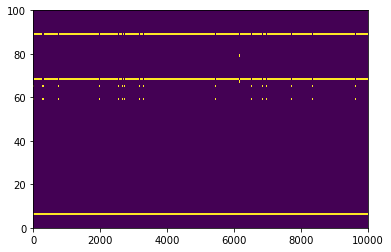

In [33]:
plt.pcolormesh(A)

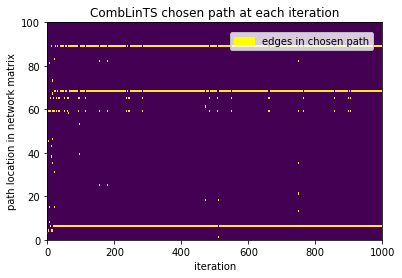

In [37]:
plt.pcolor(A[:,1:1000], label = "edges in chosen path")
plt.xlabel("iteration")
plt.ylabel("path location in network matrix")
plt.title("CombLinTS chosen path at each iteration")
yellow_patch = mpatches.Patch(color='yellow', label='edges in chosen path')
plt.legend(handles=[yellow_patch], bbox_to_anchor=(0.53, 0.98), loc=2)
plt.savefig('stoch_network_CombLinTS.pdf')

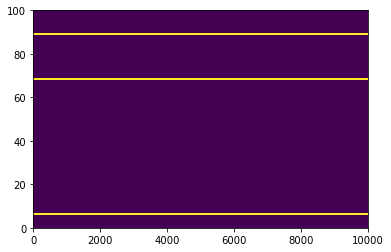

In [34]:
plt.pcolormesh(np.repeat(dijk(path_means1.reshape(L,))[1],iters).reshape(L,iters))

In [ ]:
plt.pcolormesh(np.repeat(dijk(path_means1.reshape(L,))[1],10).reshape(L,10))

In [39]:
np.sum(A*(w_actual))

3553.0877447989833

In [46]:
np.sum((np.repeat(dijk(path_means1.reshape(L,))[1],10000).reshape(L,10000))*w_actual)

3517.1562144462278

# Adversarial Case

In [128]:
V = 10
diag_zero = np.ones(L).reshape(V, V) - np.diag(np.ones(V))

path_means1 = np.zeros(L).reshape(V, V)
for i in range(V):
    for j in range(V):
        path_means1[i,j] = abs(i - j)/V - 1/(V*2)
path_means1 = abs(path_means1 * diag_zero)

In [129]:
iters = 10000
L = V*V
w = np.zeros((L, iters))
lower = 0
upper = 1
sigma = 0.01
path_means2 = pickle.load(open('adv_net1_pm2', 'rb'))
for t in range(iters):
    # select path means
    if t < iters/2:
        path_means = path_means1
    else:
        path_means = path_means2

    # draw weights
    w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means)/sigma, (upper-path_means)/sigma, loc=path_means, scale=sigma)*diag_zero)

In [130]:
d=L
phi = np.eye(L)
w_est = np.zeros((L, iters))
#w_actual = np.zeros((L, iters))
A = np.zeros((L, iters))
theta = np.zeros((d, iters+1))
### INIT
t=0
lamb = 10
sigma = 0.1
cov_mat = [np.diag([lamb**2]*d)]*(iters+1)
theta[:,t] = [0]*d

In [131]:
### iterate over number of iterations
for t in tqdm(range(iters)):
    # draw sample theta and use to estimate w
    theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])
    w_est[:,t] = np.maximum(np.dot(phi, theta_sample),0)
    # Solve oracle for w_est and get A_t - can be any number of elements
    (edges, A[:,t]) = dijk(w_est[:,t])

    # calcualate actual w based on theta_opt plus some noise
    #w_actual_noise = np.random.normal(0, sigma_true**2, L)
    #w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)
    #w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means1)/sigma_true, (upper-path_means1)/sigma_true, loc=path_means1, scale=sigma_true)*diag_zero)
    
    # update covariance matrix and theta
    # init
    theta[:,(t+1)] = theta[:,t]
    cov_mat[t+1] = cov_mat[t]
    for k in edges:
        # update theta
        theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),(phi[k,:][np.newaxis]))) / 
                              (np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2))) , 
                (theta[:,(t+1)].reshape(d,1)))).reshape(d) + (
        np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)),w_actual[k,t])).reshape(d)
        
        # update covariance matrix
        cov_mat[t+1] = (cov_mat[t+1] -
         ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),phi[k,:][np.newaxis]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)))

100%|██████████| 10000/10000 [01:08<00:00, 146.00it/s]


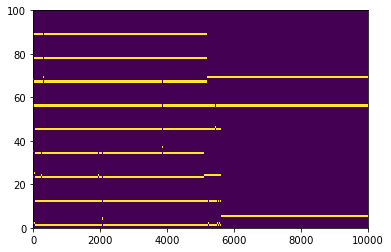

In [132]:
plt.pcolormesh(A)

In [118]:
a=np.repeat(dijk(path_means1.reshape(L,))[1],iters/2).reshape(L,int(iters/2)).shape

In [119]:
b=np.repeat(dijk(path_means2.reshape(L,))[1],iters/2).reshape(L,int(iters/2)).shape

In [133]:
np.sum(A*(w_actual))

5907.2389979619702

In [137]:
print(np.sum(A[:,:1000]*w_actual[:,:1000]))
print(np.sum(A[:,4500:5500]*w_actual[:,4500:5500]))
print(np.sum(A[:,9000:]*w_actual[:,9000:]))

482.373456357
1488.75401318
494.914726588


# Network 2

In [180]:
iters = 10000
path_means3 = np.ones(L).reshape(V, V)
for i in range(V):
    for j in range(V):
        path_means3[i,j] = abs(i - j)/V + 5/(V*2)
path_means3 = abs(path_means3 * diag_zero)

path_means4 = np.ones(L).reshape(V, V)
for i in range(V-1):
    path_means4[i, i+1] = 1/(V*2)

# trunc norm params
lower = 0
upper = 1
sigma = 0.01

w = np.zeros((L, iters))
for t in range(iters):
    # select path means
    if int(t/1000)/2==int(int(t/1000)/2):
        path_means = path_means3
    else:
        path_means = path_means4

    # draw weights
    w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means)/sigma, (upper-path_means)/sigma, loc=path_means, scale=sigma)*diag_zero)

In [181]:
d=L
phi = np.eye(L)
w_est = np.zeros((L, iters))
#w_actual = np.zeros((L, iters))
A = np.zeros((L, iters))
theta = np.zeros((d, iters+1))
### INIT
t=0
lamb = 10
sigma = 1
cov_mat = [np.diag([lamb**2]*d)]*(iters+1)
theta[:,t] = [0]*d

In [182]:
### iterate over number of iterations
for t in tqdm(range(iters)):
    # draw sample theta and use to estimate w
    theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])
    w_est[:,t] = np.maximum(np.dot(phi, theta_sample),0)
    # Solve oracle for w_est and get A_t - can be any number of elements
    (edges, A[:,t]) = dijk(w_est[:,t])

    # calcualate actual w based on theta_opt plus some noise
    #w_actual_noise = np.random.normal(0, sigma_true**2, L)
    #w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)
    #w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means1)/sigma_true, (upper-path_means1)/sigma_true, loc=path_means1, scale=sigma_true)*diag_zero)
    
    # update covariance matrix and theta
    # init
    theta[:,(t+1)] = theta[:,t]
    cov_mat[t+1] = cov_mat[t]
    for k in edges:
        # update theta
        theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),(phi[k,:][np.newaxis]))) / 
                              (np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2))) , 
                (theta[:,(t+1)].reshape(d,1)))).reshape(d) + (
        np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)),w_actual[k,t])).reshape(d)
        
        # update covariance matrix
        cov_mat[t+1] = (cov_mat[t+1] -
         ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),phi[k,:][np.newaxis]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)))

100%|██████████| 10000/10000 [00:37<00:00, 269.27it/s]


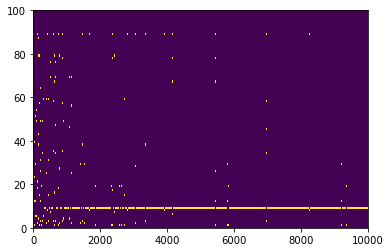

In [183]:
plt.pcolormesh(A)

In [184]:
np.sum(A*(w_actual))

10828.84996134283

In [185]:
print(np.sum(A[:,:1000]*w_actual[:,:1000]))
print(np.sum(A[:,4500:5500]*w_actual[:,4500:5500]))
print(np.sum(A[:,9000:]*w_actual[:,9000:]))

1489.0963299
1018.82804655
1001.03837772


In [187]:
adversarial_network2_CLTS_cumul_cost = np.zeros(int(iters/10))
for t in tqdm(range(0, iters, 10)):
    adversarial_network2_CLTS_cumul_cost[int(t/10)] = np.sum(A[:,:t]*w_actual[:,:t])
pickle.dump(adversarial_network2_CLTS_cumul_cost, open('net2_clts_cost', 'wb'))

100%|██████████| 1000/1000 [00:01<00:00, 739.03it/s]


# Network 3

In [174]:
iters = 10000
# setup different 'shifts' to the sine wave so that different paths have different starting points on the wave
sine_wave_shift = np.zeros(L).reshape(V, V)
for i in range(V):
    for j in range(V):
        sine_wave_shift[i,j] = abs(i - j)/(V)

# parameter which determines how many repetitions of the sine wave
sine_wave_reps = 2

# set an adjustment to subtract from each path weight mean to encourage longer paths
adjust = 0.00

# setting trunc norm means for each iteration
trunc_norm_means = np.zeros((L, iters))
for t in range(iters):
    trunc_norm_means[:,t] = np.concatenate(((np.sin((sine_wave_shift+t*sine_wave_reps/(iters))*np.pi)+1)/2-adjust)*diag_zero)

# draw weights for entire period
# trunc norm params
lower = 0
upper = 1
sigma = 0.1

w_actual = truncnorm.rvs((lower-trunc_norm_means)/sigma, (upper-trunc_norm_means)/sigma, loc=trunc_norm_means, scale=sigma)


In [175]:
d=L
phi = np.eye(L)
w_est = np.zeros((L, iters))
#w_actual = np.zeros((L, iters))
A = np.zeros((L, iters))
theta = np.zeros((d, iters+1))
### INIT
t=0
lamb = 10
sigma = 50
cov_mat = [np.diag([lamb**2]*d)]*(iters+1)
theta[:,t] = [0]*d

In [176]:
### iterate over number of iterations
for t in tqdm(range(iters)):
    # draw sample theta and use to estimate w
    theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])
    w_est[:,t] = np.maximum(np.dot(phi, theta_sample),0)
    # Solve oracle for w_est and get A_t - can be any number of elements
    (edges, A[:,t]) = dijk(w_est[:,t])

    # calcualate actual w based on theta_opt plus some noise
    #w_actual_noise = np.random.normal(0, sigma_true**2, L)
    #w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)
    #w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means1)/sigma_true, (upper-path_means1)/sigma_true, loc=path_means1, scale=sigma_true)*diag_zero)
    
    # update covariance matrix and theta
    # init
    theta[:,(t+1)] = theta[:,t]
    cov_mat[t+1] = cov_mat[t]
    for k in edges:
        # update theta
        theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),(phi[k,:][np.newaxis]))) / 
                              (np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2))) , 
                (theta[:,(t+1)].reshape(d,1)))).reshape(d) + (
        np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)),w_actual[k,t])).reshape(d)
        
        # update covariance matrix
        cov_mat[t+1] = (cov_mat[t+1] -
         ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),phi[k,:][np.newaxis]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)))

100%|██████████| 10000/10000 [00:42<00:00, 237.13it/s]


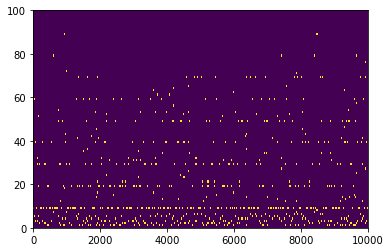

In [177]:
plt.pcolormesh(A)

In [178]:
np.sum(A*(w_actual))

9488.7643941921961

In [179]:
print(np.sum(A[:,:1000]*w_actual[:,:1000]))
print(np.sum(A[:,4500:5500]*w_actual[:,4500:5500]))
print(np.sum(A[:,9000:]*w_actual[:,9000:]))

1338.20902733
406.48675308
1593.74574147


# Basic case

In [72]:
### Set parameters
L = 20
K = 5
iters = 10000
bern_means = np.array([x/L for x in range(L)])
#U = np.zeros((L, iters))
A = np.zeros((L, iters))
w_actual = np.zeros((L, iters))
#w_observed = np.zeros((L, iters))
for t in range(iters):
    # Draw new weights and store in w
    w_actual[:,t] = np.random.binomial(1, bern_means)

t = 0
# Initial observation of weight for each element
#w_est[:,t] = w_actual[:,t]

In [73]:
w_actual[:,1]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  1.,  1.])

In [74]:
#lambda_true = 0.1 # (used to generate true coefficients of Φ which are then used to calculate w̄ )
#sigma_true = 0.2 # (used when adding noise to true w at each iteration)
d = L
#phi = np.random.normal(0, 1, (L,d))
phi = np.eye(L)
#phi = np.random.uniform(0, 1, L*d).reshape(L,d)
#theta_opt = np.random.multivariate_normal([0]*d, np.diag([lambda_true**2]*d))
w_bar = bern_means.reshape(L,)
#w_bar = np.array([0,100,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
#w_bar = np.array([0,10,1,100,5,0,5,1,5,1,0,100,5,5,5,0])
theta_opt = np.linalg.solve(phi,w_bar)

In [75]:
w_est = np.zeros((L, iters))
theta = np.zeros((d, iters+1))
### INIT
t=0
lamb = 10
sigma = 1
cov_mat = [np.diag([lamb**2]*d)]*(iters+1)
theta[:,t] = [0]*d

In [76]:
### iterate over number of iterations
for t in tqdm(range(iters)):
    # draw sample theta and use to estimate w
    theta_sample = np.random.multivariate_normal(theta[:,t], cov_mat[t])
    w_est[:,t] = np.dot(phi, theta_sample)
    # Solve oracle for w_est and get A_t - can be any number of elements
    (edges, A[:,t]) = myorac(w_est[:,t],K)
    

    # calcualate actual w based on theta_opt plus some noise
    #w_actual_noise = np.random.normal(0, sigma_true**2, L)
    #w_actual[:,t] = np.maximum(0,w_bar + w_actual_noise)
    #w_actual[:,t] = np.concatenate(truncnorm.rvs((lower-path_means1)/sigma_true, (upper-path_means1)/sigma_true, loc=path_means1, scale=sigma_true)*diag_zero)
    
    # update covariance matrix and theta
    # init
    theta[:,(t+1)] = theta[:,t]
    cov_mat[t+1] = cov_mat[t]
    for k in edges:
        # update theta
        theta[:,(t+1)]=(np.dot(((np.eye(d))-((np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),(phi[k,:][np.newaxis]))) / 
                              (np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2))) , 
                (theta[:,(t+1)].reshape(d,1)))).reshape(d) + (
        np.dot(((np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)),w_actual[k,t])).reshape(d)
        
        # update covariance matrix
        cov_mat[t+1] = (cov_mat[t+1] -
         ((np.dot(np.dot(np.dot(cov_mat[t+1],np.transpose(phi[k,:][np.newaxis])),phi[k,:][np.newaxis]),cov_mat[t+1]))/(np.dot(np.dot(phi[k,:][np.newaxis],cov_mat[t+1]),np.transpose(phi[k,:][np.newaxis])) + sigma**2)))

100%|██████████| 10000/10000 [00:05<00:00, 1782.63it/s]


In [77]:
def myorac(w,K):
    edges = np.argsort(w)[-K:]
    #A = np.arange(len(w))
    A = np.zeros(len(w))
    A[edges] = 1
    return(edges, A)

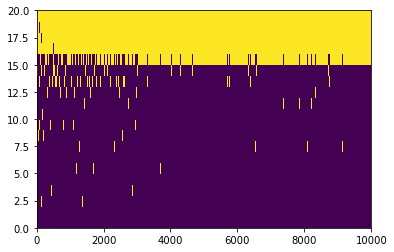

In [78]:
plt.pcolormesh(A)

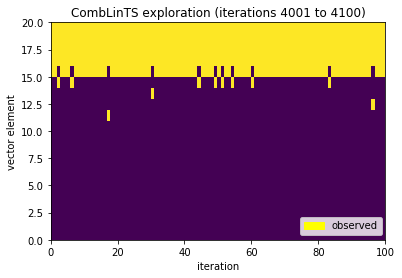

In [79]:
# plot development of selected elements
plt.pcolor(A[:,1:100], label = "observed")
plt.xlabel("iteration")
plt.ylabel("vector element")
plt.title("CombLinTS exploration (first 100 iterations)")
yellow_patch = mpatches.Patch(color='yellow', label='observed')
plt.legend(handles=[yellow_patch], bbox_to_anchor=(0.73, 0.13), loc=2)
plt.savefig('basicCombLinTS_100iters.pdf')

plt.pcolor(A[:,100:200], label = "observed")
plt.xlabel("iteration")
plt.ylabel("vector element")
plt.title("CombLinTS exploration (iterations 101 to 200)")
yellow_patch = mpatches.Patch(color='yellow', label='observed')
plt.legend(handles=[yellow_patch], bbox_to_anchor=(0.73, 0.13), loc=2)
plt.savefig('basicCombLinTS_100_200iters.pdf')

plt.pcolor(A[:,4000:4100], label = "observed")
plt.xlabel("iteration")
plt.ylabel("vector element")
plt.title("CombLinTS exploration (iterations 4001 to 4100)")
yellow_patch = mpatches.Patch(color='yellow', label='observed')
plt.legend(handles=[yellow_patch], bbox_to_anchor=(0.73, 0.13), loc=2)
plt.savefig('basicCombUCB1_4000_4100iters.pdf')

In [80]:
best_return = np.sum(w_actual[-K:,:])

In [46]:
w_actual.shape

(20, 10000)

In [81]:
best_return

42487.0

In [82]:
np.sum(w_est[-K:])

42515.552449872848

In [36]:
w_est.shape

(20, 10000)

In [37]:
w_est[:,1]

array([ 13.6058643 , -12.02575263,   1.20389459,  -5.49325296,
        -0.66836392,  -6.09182728,   9.88223842,   0.03196445,
         0.96779063,   0.18199991,   1.06039821,  -2.78609966,
        -0.48598709,   0.91116149,  16.28429995,   1.00708181,
        -9.35767965,  10.89321251,  -7.49667006,  18.60439401])

In [83]:
np.sum(A*w_actual)

42018.0

In [42]:
A[:,1]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  1.])

In [59]:
myorac(bern_means,3)

(array([17, 18, 19]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.]))

In [60]:
bern_means

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95])